In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%ls -ltrh /Users/laurentperrinet/quantic/grants/Polychronies/RSG-spikepatterns/Data/

total 2267760
-rw-r--r--  1 laurentperrinet  staff   211M Jun 14 10:42 H_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--  1 laurentperrinet  staff   407M Jun 14 10:55 G_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--@ 1 laurentperrinet  staff   2.0K Jun 15 12:29 README.md
-rw-r--r--@ 1 laurentperrinet  staff   183M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff   212M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=1.npz
-rw-r--r--@ 1 laurentperrinet  staff    17M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff    68M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=1.npz


In [3]:
i_session = 0
monkey = 'G'
from pathlib import Path
path = Path.home()/'quantic'/'grants'/'polychronies'/'RSG-spikepatterns'/'Data'/f'{monkey}_Ready-Set_bin1ms_alignedReady_session={i_session}.npz'

dictdata = np.load(path)
data, id_neuron, id_short, t_s, t_p = dictdata['data'], dictdata['id_neuron'], dictdata['id_short'], dictdata['t_s'], dictdata['t_p']
data = data.astype(float)
data[data==255] = np.nan
N_time, N_neuron, N_trial = data.shape

N_time, N_neuron, N_trial

(1200, 107, 1498)

### computing the firing rates

In [4]:
t_s_max = int(t_s.max())
DeltaT = 100 # number of time bins on which we average
dt = 40 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, t_s_max+1, dt)
N_timepoint = len(timepoints)
timepoints, N_timepoint

(array([ 100,  140,  180,  220,  260,  300,  340,  380,  420,  460,  500,
         540,  580,  620,  660,  700,  740,  780,  820,  860,  900,  940,
         980, 1020, 1060, 1100, 1140, 1180]),
 28)

In [5]:
fr = np.empty((N_timepoint, N_neuron, N_trial)) * np.nan
for i_timepoint, timepoint in enumerate(timepoints):
    fr[i_timepoint, :, :] = np.nansum(data[(timepoint-DeltaT):timepoint, :, :], axis=0) / (DeltaT/1000)

In [6]:
# for i_trial in range(N_trial):
#     print(i_trial, torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum())
#     break
# torch.isnan(torch.tensor(fr.astype(float))).sum(), torch.isnan(torch.tensor(data.astype(float))).sum()

In [7]:
fr.shape

(28, 107, 1498)

In [8]:
ratio_train = 80/100
N_trial_train = int(N_trial*ratio_train)
N_trial_test = N_trial - N_trial_train
idx_trial = np.random.permutation(N_trial)
idx_trial

array([ 663, 1047,  209, ...,  217,  604, 1141])

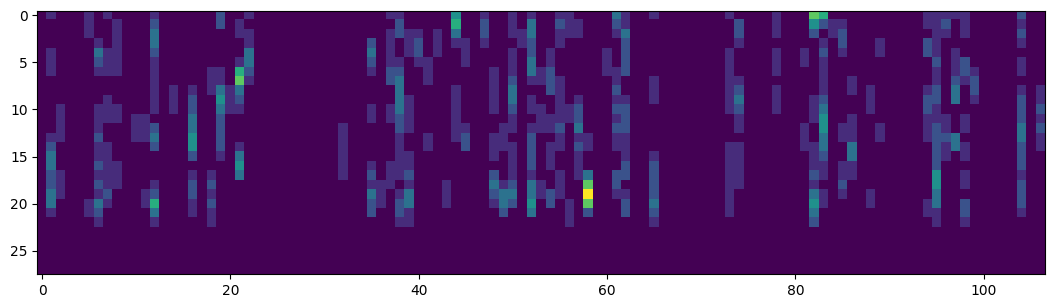

In [9]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(fr[:, :, 102], cmap='viridis')

### logistic regression model with NaNs

### inference model

In [10]:
import torch
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

device = 'cpu'

In [11]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# torch.set_default_tensor_type("torch.FloatTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size


class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N_neuron, N_timepoint, logit_0=-2., logit_wt=0.1):
        super(LogisticRegressionModel, self).__init__() 
        self.bias = torch.nn.Parameter(logit_0*torch.ones(1, N_timepoint))
        self.weight = torch.nn.Parameter(logit_wt * torch.randn((N_neuron, N_timepoint)))
        # self.nl = torch.nn.Softmax(N_timepoint)
        # self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_neuron
        X_input[torch.isnan(X_input)] = 0.
        # return self.nl(X_input @ self.weight +  self.bias)
        # print(X_input.dtype, self.bias.dtype, self.weight.dtype)
        return F.softmax(torch.tensordot(X_input, self.weight, dims=1) +  self.bias, dim=1)

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [12]:
# F.softmax?
# torch.tensor?

In [13]:
logistic_model = LogisticRegressionModel(N_neuron, N_timepoint)
i_trial = 3
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
outputs = logistic_model(X)
X.shape, outputs.shape

(torch.Size([28, 107]), torch.Size([28, 28]))

In [14]:
X.sum(axis=1), (X.sum(axis=1)>0).shape

(tensor([480., 490., 440., 370., 390., 520., 610., 490., 410., 440., 420., 460.,
         480., 530., 500., 430., 480., 470., 410., 480., 540., 350., 100.,   0.,
           0.,   0.,   0.,   0.]),
 torch.Size([28]))

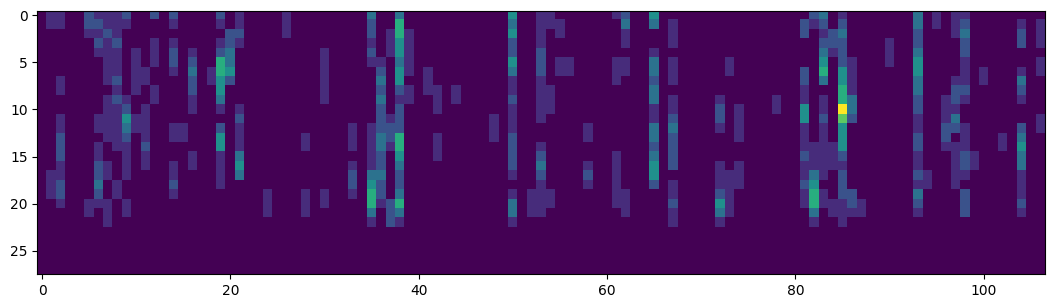

In [15]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(X.numpy(), cmap='viridis')

In [16]:
N_timepoint, np.arange(N_timepoint),  np.arange(N_timepoint)[X.sum(axis=1)>0]


(28,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]))

In [17]:
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
X = X[time_labels, :]
outputs = logistic_model(X)
time_labels, X.shape, outputs.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 torch.Size([23, 107]),
 torch.Size([23, 28]))

In [18]:
F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

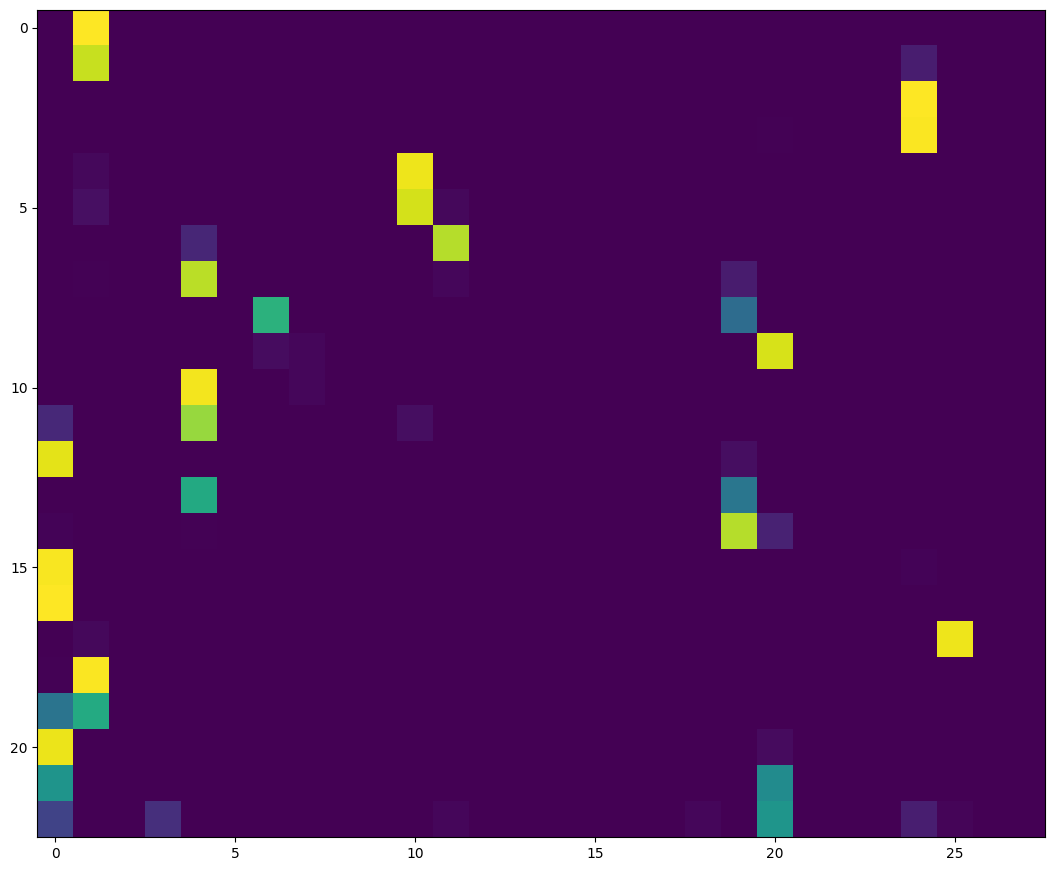

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs.detach().numpy(), cmap='viridis')

In [20]:
learning_rate = 0.005
logit_0 = -2.
logit_wt = 0.1
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(fr, logit_0=logit_0, logit_wt=0.1,
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                betas=betas, amsgrad=amsgrad,
                verbose=False, 
        ):

    logistic_model = LogisticRegressionModel(N_neuron, N_timepoint, logit_0=logit_0, logit_wt=logit_wt)
    # logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for i_trial in idx_trial[range(N_trial_train)]:
            X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
            time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
            X = X[time_labels, :]
            labels = F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.
            # X, labels = X.to(device), labels.to(device)
            outputs = logistic_model(X)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    return logistic_model, np.mean(losses)

logistic_model, loss = fit_data(fr, verbose=True)

Iteration: 0 - Loss: 0.26916
Iteration: 16 - Loss: 0.21296
Iteration: 32 - Loss: 0.21949
Iteration: 48 - Loss: 0.22038
Iteration: 64 - Loss: 0.22505
Iteration: 80 - Loss: 0.21974
Iteration: 96 - Loss: 0.21978
Iteration: 112 - Loss: 0.21632
Iteration: 128 - Loss: 0.21616
Iteration: 144 - Loss: 0.22156
Iteration: 160 - Loss: 0.21710
Iteration: 176 - Loss: 0.22197
Iteration: 192 - Loss: 0.21379
Iteration: 208 - Loss: 0.21562
Iteration: 224 - Loss: 0.20799
Iteration: 240 - Loss: 0.21564
Iteration: 256 - Loss: 0.22121
Iteration: 272 - Loss: 0.22139
Iteration: 288 - Loss: 0.22613
Iteration: 304 - Loss: 0.21577
Iteration: 320 - Loss: 0.21251
Iteration: 336 - Loss: 0.21311
Iteration: 352 - Loss: 0.21409
Iteration: 368 - Loss: 0.22291
Iteration: 384 - Loss: 0.21856
Iteration: 400 - Loss: 0.21764
Iteration: 416 - Loss: 0.21829
Iteration: 432 - Loss: 0.21624
Iteration: 448 - Loss: 0.22268
Iteration: 464 - Loss: 0.22420
Iteration: 480 - Loss: 0.22663
Iteration: 496 - Loss: 0.22219
Iteration: 512 -

In [21]:
logistic_model.weight.detach().numpy().shape, logistic_model.weight.detach().numpy().ravel().shape

((107, 28), (2996,))

In [22]:
with torch.no_grad():
    counts = np.zeros((N_timepoint, N_timepoint))
    outputs = np.zeros((N_timepoint, N_timepoint))
    for i_trial in idx_trial[range(N_trial_train, N_trial)]:
        X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
        time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
        counts[time_labels, :] += 1
        X = X[time_labels, :]
        output = logistic_model(X).numpy()
        outputs[time_labels, :] += output

    outputs = outputs/counts

outputs.shape, counts, outputs.sum(axis=1)

(array([[1.49623098e-01, 9.05409571e-02, 2.48813715e-01, 2.02208711e-01,
         4.56785712e-02, 2.48544323e-02, 1.72348042e-02, 1.88522889e-03,
         7.48085126e-03, 5.74939404e-03, 1.17504532e-02, 2.38937024e-03,
         1.07884144e-02, 3.12046457e-02, 1.27909506e-02, 1.94875451e-02,
         2.44726499e-03, 3.67095596e-02, 5.79594527e-04, 1.65554646e-02,
         1.14792491e-02, 4.97976269e-03, 1.77547579e-03, 1.15538885e-02,
         8.54566815e-03, 1.70840784e-02, 5.46718599e-03, 3.41665122e-04],
        [1.20934639e-01, 8.92571964e-02, 2.39206121e-01, 2.28376445e-01,
         5.89895866e-02, 2.97299879e-02, 2.40473349e-02, 2.49226898e-03,
         5.25144645e-03, 4.59022439e-03, 1.04712526e-02, 3.28461952e-03,
         8.95103551e-03, 3.21673738e-02, 1.22011992e-02, 1.66006359e-02,
         2.73464895e-03, 3.57285384e-02, 7.39899254e-04, 2.15297612e-02,
         1.06819014e-02, 3.95304308e-03, 5.69870920e-04, 1.06015777e-02,
         7.44443537e-03, 1.09199577e-02, 7.9718648

In [23]:
outputs.min(), outputs.max()

(3.737598468235371e-05, 0.3108257072618955)

In [24]:
counts.min(), counts.max()

(53.0, 300.0)

In [25]:
torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum(), 

(tensor(0),)

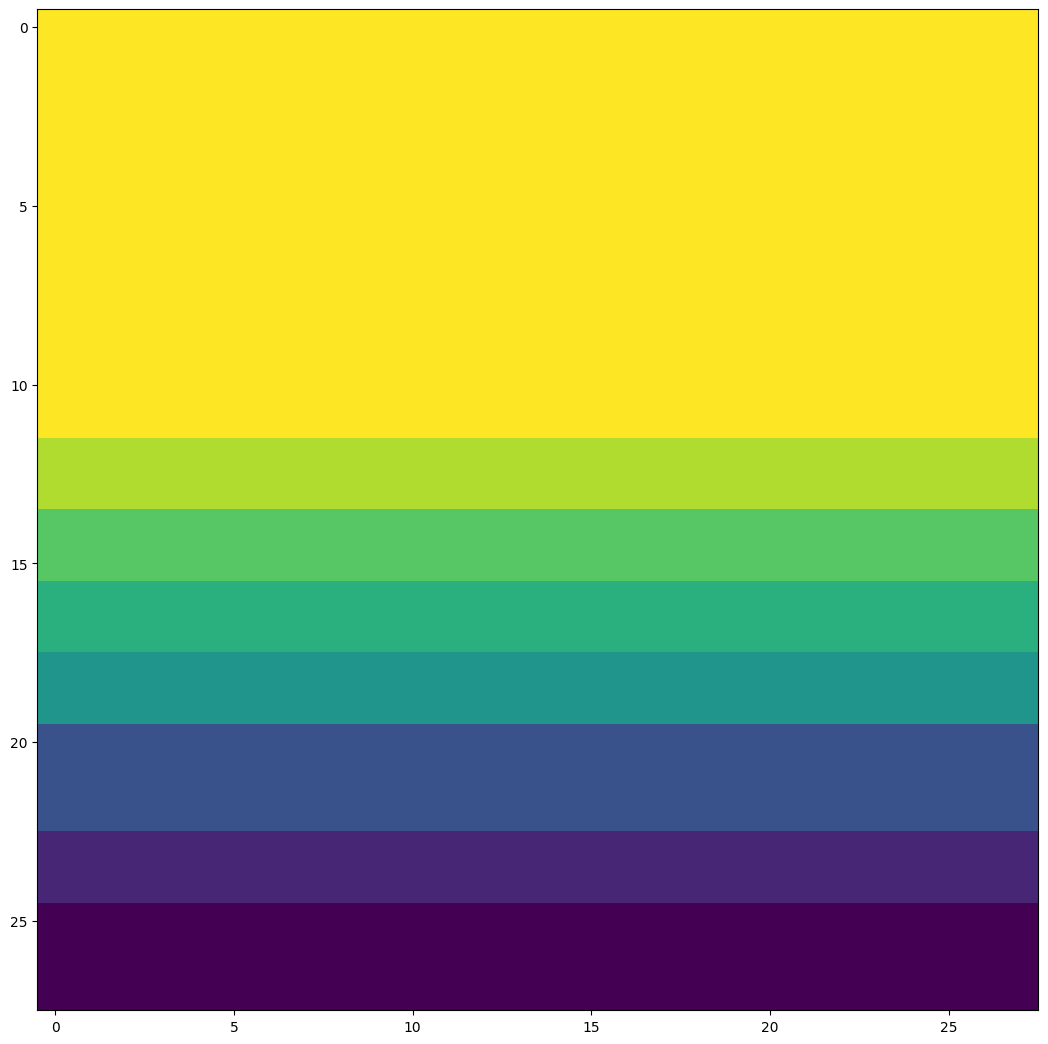

In [26]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(counts, cmap='viridis')

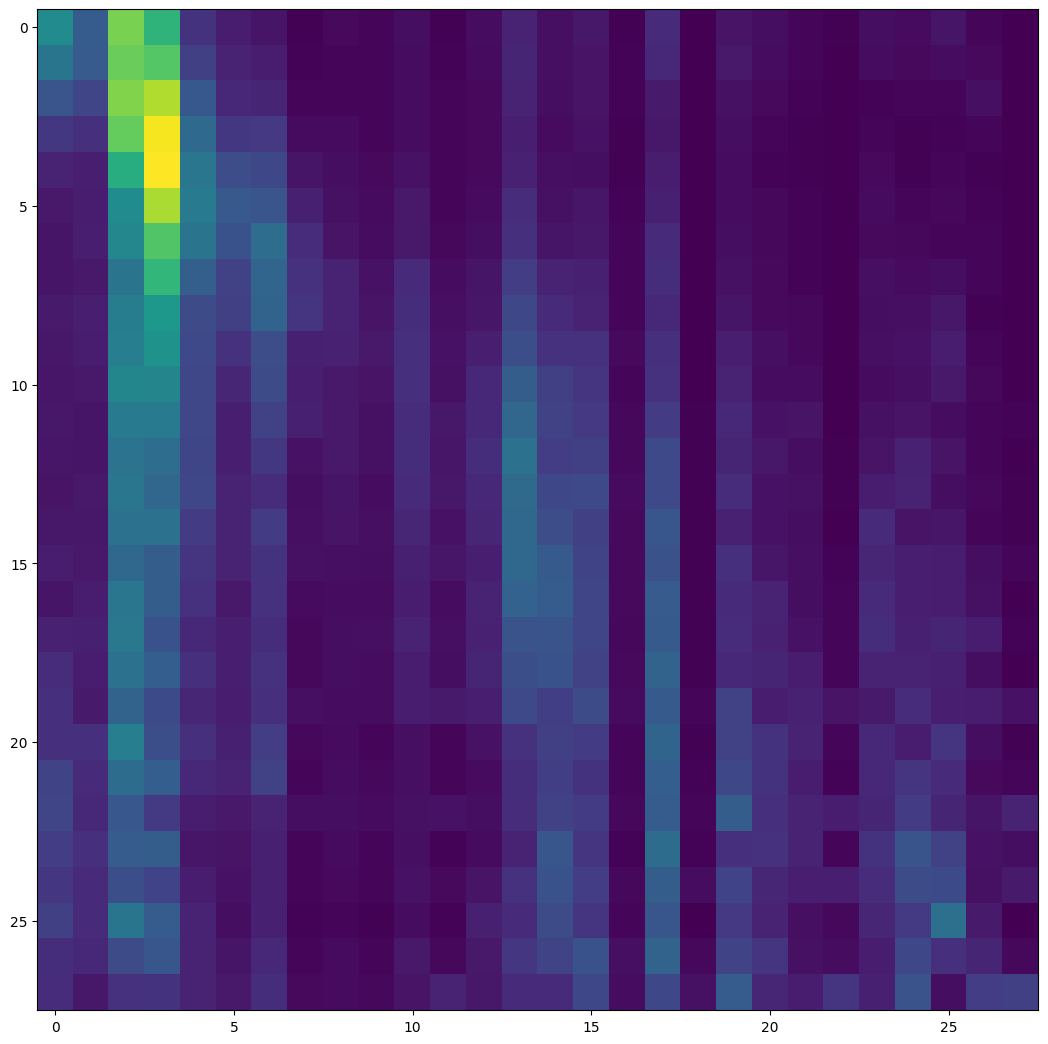

In [27]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs, cmap='viridis')
ax.set_xlabel('predicted time')
ax.set_ylabel('true time')

In [28]:
outputs[:5, :5]

array([[0.1496231 , 0.09054096, 0.24881372, 0.20220871, 0.04567857],
       [0.12093464, 0.0892572 , 0.23920612, 0.22837644, 0.05898959],
       [0.08250789, 0.06440838, 0.25139075, 0.27322139, 0.08579353],
       [0.05049034, 0.04355862, 0.23797978, 0.30681578, 0.10640598],
       [0.02935701, 0.02575586, 0.19359634, 0.31082571, 0.12234451]])

## scan parameters

In [30]:

N_scan = 5
for logit_0_learning_rate_ in learning_rate*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, learning_rate=learning_rate_, verbose=False)
    print(f'learning_rate={learning_rate_}:{loss=:.3f}')

learning_rate=0.0005:loss=0.1343111804733142
learning_rate=0.0015811388300841897:loss=0.14424055619001297
learning_rate=0.005:loss=0.21139040769991674


In [ ]:
for logit_0_ in logit_0*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_0=logit_0_, verbose=False)
    print(f'logit_0={logit_0_}:{loss=:.3f}')

In [ ]:
for logit_wt_ in logit_wt*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_wt=logit_wt_, verbose=False)
    print(f'logit_wt={logit_wt_}:{loss=:.3f}')

In [ ]:
for beta1_ in 1-np.logspace(-1, -4, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta1=beta1_, verbose=False)
    print(f'beta1={beta1_}:{loss=:.3f}')

In [ ]:
for beta2_ in 1-np.logspace(-1, -4, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta2=beta2_, verbose=False)
    print(f'beta2={beta2_}:{loss=:.3f}')